In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from tqdm import trange

from glob import glob
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.applications import MobileNetV2,NASNetMobile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [2]:
Yes_path = glob('brain_tumor_dataset/yes/*')
No_path = glob('brain_tumor_dataset/no/*')

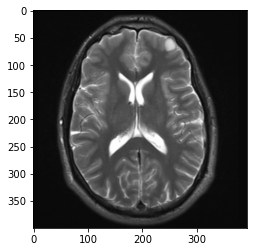

In [3]:
plt.imshow(cv2.imread(No_path[90]))

In [4]:
images = []
labels = []

IMG_D = 224

for im_path in No_path:
    img = cv2.imread(im_path)
    img = cv2.resize(img,(IMG_D,IMG_D))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(0)
    
for im_path in Yes_path:
    img = cv2.imread(im_path)
    img = cv2.resize(img,(IMG_D,IMG_D))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(1)
    
images = np.array(images)
images = images/255.0
labels = np.array(labels)
print(images.shape)
print(labels.shape)

(253, 224, 224, 3)
(253,)


In [5]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T) 

[[  0  98]
 [  1 155]]


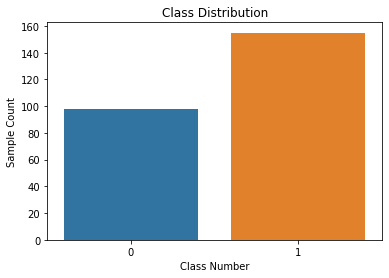

In [7]:
# class distrubiton
plt.subplots(figsize=(6,4))
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xlabel("Class Number")
plt.ylabel("Sample Count")
plt.show()

In [8]:
feature_extractor = NASNetMobile(input_shape=(IMG_D,IMG_D,3), include_top=False)

In [9]:
feature_extractor.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

activation_157 (Activation)     (None, 7, 7, 176)    0           adjust_bn_10[0][0]               
__________________________________________________________________________________________________
activation_159 (Activation)     (None, 7, 7, 176)    0           adjust_bn_10[0][0]               
__________________________________________________________________________________________________
activation_161 (Activation)     (None, 7, 7, 176)    0           normal_bn_1_10[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_left1_1 (None, 7, 7, 176)    35376       activation_153[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_right1_ (None, 7, 7, 176)    32560       activation_155[0][0]             
__________________________________________________________________________________________________
separable_

In [10]:
Ext_data = feature_extractor.predict(images)

In [11]:
print('Orginal image data shape:',images.shape)
print('Extracted image data shape:',Ext_data.shape)

Orginal image data shape: (253, 224, 224, 3)
Extracted image data shape: (253, 7, 7, 1056)


In [12]:
# Resizing the Extracted image(feature) shape
Ext_data = Ext_data.reshape(Ext_data.shape[0],-1)
print(Ext_data.shape)

(253, 51744)


In [13]:
print(len(Ext_data),len(labels))

253 253


In [14]:
X_train, X_test, y_train, y_test = train_test_split(Ext_data,labels, train_size=0.25, random_state=10)

## Random forest

In [65]:
rf = []
for i in trange(1,1001):
    RF_model = RandomForestClassifier(n_estimators = i, random_state = 42)
    RF_model.fit(X_train, y_train)
    rf.append(accuracy_score(y_test, RF_model.predict(X_test)))
    


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:16<00:00,  1.04s/it]


In [66]:
print(rf)

[0.6947368421052632, 0.6105263157894737, 0.7263157894736842, 0.7, 0.7052631578947368, 0.6736842105263158, 0.7368421052631579, 0.7421052631578947, 0.7631578947368421, 0.7421052631578947, 0.7789473684210526, 0.7421052631578947, 0.7684210526315789, 0.7789473684210526, 0.7947368421052632, 0.8157894736842105, 0.8052631578947368, 0.8052631578947368, 0.8, 0.7947368421052632, 0.7894736842105263, 0.7947368421052632, 0.8, 0.8052631578947368, 0.8263157894736842, 0.8315789473684211, 0.8263157894736842, 0.8105263157894737, 0.8052631578947368, 0.8052631578947368, 0.8157894736842105, 0.8157894736842105, 0.8210526315789474, 0.8210526315789474, 0.8315789473684211, 0.8473684210526315, 0.8526315789473684, 0.8421052631578947, 0.8473684210526315, 0.8315789473684211, 0.8421052631578947, 0.8368421052631579, 0.8263157894736842, 0.8368421052631579, 0.8315789473684211, 0.8368421052631579, 0.8421052631578947, 0.8473684210526315, 0.8421052631578947, 0.868421052631579, 0.8315789473684211, 0.8315789473684211, 0.821

In [71]:
np.max(rf)

0.8789473684210526

In [72]:
np.argmax(rf)

514

In [73]:
rf[514]

0.8789473684210526

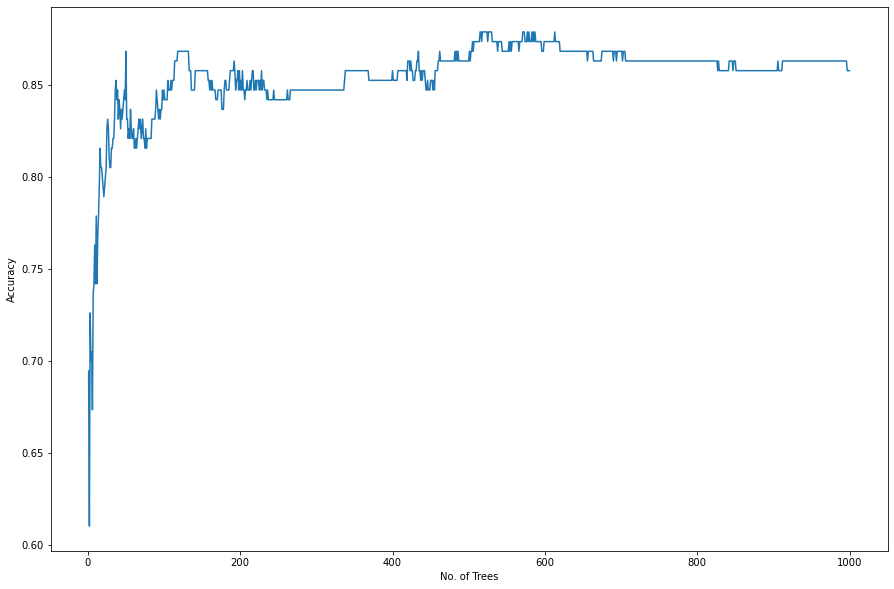

In [70]:
# print(len(rf))
# x = [i for i in range(1,1001)]
# print(len(x))
plt.figure(figsize=(15,10))
plt.plot(x,rf)
plt.xlabel("No. of Trees")
plt.ylabel("Accuracy")
plt.show()

In [74]:
RF_model = RandomForestClassifier(n_estimators = 515, random_state = 42)

# Training the model
RF_model.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=515, random_state=42)

In [75]:
print ("Training Accuracy = ", accuracy_score(y_train, RF_model.predict(X_train)))
print ("Testing Accuracy = ", accuracy_score(y_test, RF_model.predict(X_test)))

Training Accuracy =  1.0
Testing Accuracy =  0.8789473684210526


## Decision Tree

In [17]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [18]:
print ("Training Accuracy = ", accuracy_score(y_train, DT.predict(X_train)))
print ("Testing Accuracy = ", accuracy_score(y_test, DT.predict(X_test)))

Training Accuracy =  1.0
Testing Accuracy =  0.6894736842105263


## SVM

In [19]:
lin_svc = svm.SVC(kernel='linear', C=3, gamma ='scale').fit(X_train, y_train)

In [20]:
rbf_svc = svm.SVC(kernel= 'rbf', C=10,degree=50, gamma = 'auto' ).fit(X_train, y_train)

In [21]:
print ("Linear SVM Training Accuracy = ", accuracy_score(y_train, lin_svc.predict(X_train)))
print ("Linear SVM Testing Accuracy = ", accuracy_score(y_test, lin_svc.predict(X_test)))

Linear SVM Training Accuracy =  1.0
Linear SVM Testing Accuracy =  0.8473684210526315


In [22]:
print ("RBF SVM Training Accuracy = ", accuracy_score(y_train, rbf_svc.predict(X_train)))
print ("RBF SVM Testing Accuracy = ", accuracy_score(y_test, rbf_svc.predict(X_test)))

RBF SVM Training Accuracy =  1.0
RBF SVM Testing Accuracy =  0.8631578947368421


## Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [24]:
print ("Logistic Regression Training Accuracy = ", accuracy_score(y_train, lr.predict(X_train)))
print ("Logistic Regression Testing Accuracy = ", accuracy_score(y_test, lr.predict(X_test)))

Logistic Regression Training Accuracy =  1.0
Logistic Regression Testing Accuracy =  0.8631578947368421


## MLP

In [76]:
clf = MLPClassifier(random_state=19, max_iter=100,early_stopping=False,validation_fraction=0.1,verbose=2).fit(X_train, y_train)

Iteration 1, loss = 0.85291474
Iteration 2, loss = 4.75558925
Iteration 3, loss = 6.82161237
Iteration 4, loss = 6.18753663
Iteration 5, loss = 1.11592810
Iteration 6, loss = 2.00064159
Iteration 7, loss = 3.34935113
Iteration 8, loss = 2.12331242
Iteration 9, loss = 0.54278257
Iteration 10, loss = 0.31374163
Iteration 11, loss = 0.85169702
Iteration 12, loss = 1.14947694
Iteration 13, loss = 0.85245639
Iteration 14, loss = 0.38875436
Iteration 15, loss = 0.11113695
Iteration 16, loss = 0.00268120
Iteration 17, loss = 0.00074264
Iteration 18, loss = 0.00206525
Iteration 19, loss = 0.00382655
Iteration 20, loss = 0.00370579
Iteration 21, loss = 0.00198030
Iteration 22, loss = 0.00084410
Iteration 23, loss = 0.00042184
Iteration 24, loss = 0.00028277
Iteration 25, loss = 0.00023444
Iteration 26, loss = 0.00021742
Iteration 27, loss = 0.00021162
Iteration 28, loss = 0.00021015
Iteration 29, loss = 0.00021124
Iteration 30, loss = 0.00021498
Iteration 31, loss = 0.00022248
Iteration 32, los

In [77]:
print ("MLP Training Accuracy = ", accuracy_score(y_train, clf.predict(X_train)))
print ("MLP Testing Accuracy = ", accuracy_score(y_test, clf.predict(X_test)))

MLP Training Accuracy =  1.0
MLP Testing Accuracy =  0.8526315789473684


## ANN

In [156]:
model = Sequential([Dense(128,activation = 'relu',input_shape=(Ext_data.shape[1],)),
                    Dense(64,activation ='relu'),
                    Dropout(0.5),
                    Dense(1,activation ='sigmoid')])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               6623360   
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 6,631,681
Trainable params: 6,631,681
Non-trainable params: 0
_________________________________________________________________


In [162]:
model.compile(loss="binary_crossentropy",metrics=['accuracy'])

In [163]:
import tensorflow
call = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

In [172]:
history = model.fit(X_train,y_train,validation_split=0.3,epochs=14,callbacks=call)

Epoch 1/14
2/2 [==============================] - 0s 56ms/step - loss: 1.5150 - accuracy: 0.8864 - val_loss: 1.3151 - val_accuracy: 0.8421
Epoch 2/14
2/2 [==============================] - 0s 43ms/step - loss: 0.0646 - accuracy: 0.9545 - val_loss: 1.5823 - val_accuracy: 0.8421
Epoch 3/14
2/2 [==============================] - 0s 42ms/step - loss: 0.4615 - accuracy: 0.9318 - val_loss: 1.1328 - val_accuracy: 0.8947
Epoch 4/14
2/2 [==============================] - 0s 38ms/step - loss: 0.1539 - accuracy: 0.9091 - val_loss: 1.1834 - val_accuracy: 0.8421
Epoch 5/14
2/2 [==============================] - 0s 39ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.3411 - val_accuracy: 0.7895
Epoch 6/14
2/2 [==============================] - 0s 37ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.2333 - val_accuracy: 0.8421
Epoch 7/14
2/2 [==============================] - 0s 40ms/step - loss: 0.0686 - accuracy: 0.9773 - val_loss: 1.7381 - val_accuracy: 0.7895
Epoch 8/14
2/2 [===========

In [173]:
result = model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 5ms/step - loss: 1.1669 - accuracy: 0.8632


In [175]:
model.save('model.h5')

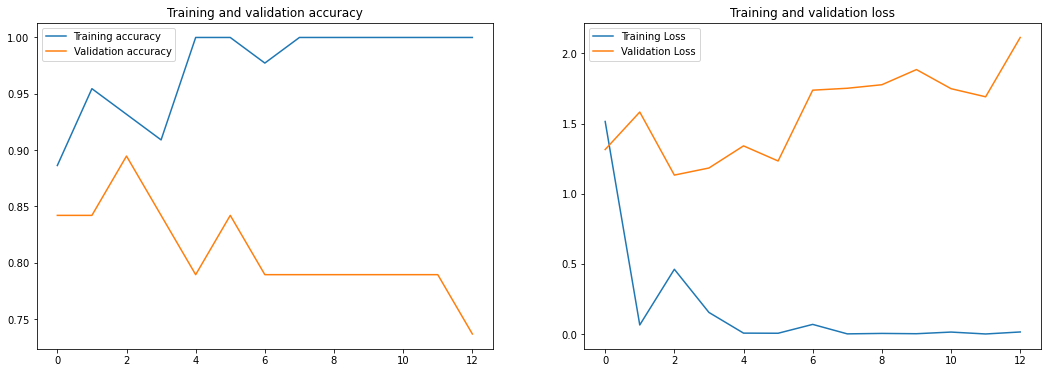

In [174]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.subplots(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Predictions

In [27]:
LABELS = ["NO","YES"]

0
NO


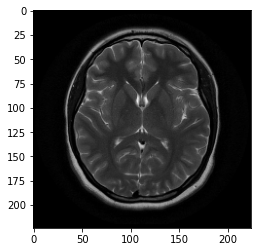

In [28]:
plt.imshow(images[0])
a = images[0]
input_img = np.expand_dims(a, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=feature_extractor.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
#RF_model.predict(input_img_features)
print(RF_model.predict(input_img_features)[0])
print(LABELS[RF_model.predict(input_img_features)[0]])

In [48]:
def predict(file_path):
    try:
        img = cv2.imread(file_path)
        img = img/255
        img = cv2.resize(img,(IMG_D,IMG_D))
        plt.imshow(img)
        input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
        input_img_feature=feature_extractor.predict(input_img)
        input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
        #RF_model.predict(input_img_features)
        #print(RF_model.predict(input_img_features)[0])
        print("Decision Tree Prediction :",LABELS[DT.predict(input_img_features)[0]])
        print("Random Forest Prediction :",LABELS[RF_model.predict(input_img_features)[0]])
        print("SVM RBF Prediction :",LABELS[rbf_svc.predict(input_img_features)[0]])
        
    except:
        print('Something went wrong')

Decision Tree Prediction : NO
Random Forest Prediction : NO
SVM RBF Prediction : NO


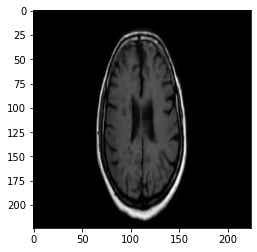

In [52]:
file_name = 'brain_tumor_dataset/no/11 no.jpg'
predict(file_name)

## Classification Report

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, RF_model.predict(X_test), target_names=LABELS))

              precision    recall  f1-score   support

          NO       0.96      0.70      0.81        71
         YES       0.85      0.98      0.91       119

    accuracy                           0.88       190
   macro avg       0.90      0.84      0.86       190
weighted avg       0.89      0.88      0.87       190



In [79]:
from sklearn import metrics
cm=metrics.confusion_matrix(y_test, RF_model.predict(X_test))
print(cm)

[[ 50  21]
 [  2 117]]


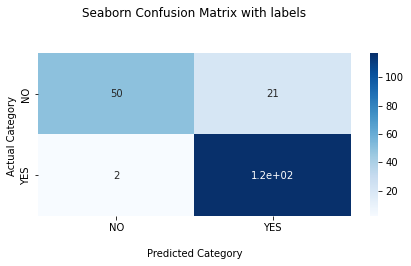

In [87]:
plt.figure(figsize=(7,3))
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS)
ax.yaxis.set_ticklabels(LABELS)

## Display the visualization of the Confusion Matrix.
plt.show()